In [1]:
import sys
sys.path.append('../')
from utility.file_utility import FileUtility
from scipy.sparse import csr_matrix
from shutil import copyfile



In [2]:
labeler=dict([tuple(x.split(',')) for x in FileUtility.load_list('../../bio_cpe_datacollection/representations/RA/grouping.csv')[1::]])

In [3]:
SRX2row=dict([(x.split('/')[-1].split('.')[0],idx) for idx, x in enumerate(FileUtility.load_list('../../bio_cpe_datacollection/representations/RA/RA_100000_cpe_10000_meta'))])

In [5]:
FileUtility.save_list('RA_lables.txt',['\t'.join([x,y]) for x,y in labeler.items()])

## Bootstrapping

In [40]:
from bootstrapping.bootstrapping import BootStrapping


In [42]:
BT=BootStrapping('a','b','c')
BT.load('../../16S_datasets/ra/boot/results_bootstrapping_synthetic.pickle')
BT.plotting_cpe('Arthiris','Arthiris',ylimv=100,ratio=100)

## Marker finding

In [4]:
from taxonomic_assignment.Seq2Tax import Seq2Tax
def get_matrix_label(X, labeler, SRX2row, pos=[], neg=[]):
    label_vec=[]
    X=X.toarray()
    New_X=[]
    for srx,label in labeler.items():
        if label in pos:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(1)
        elif label in neg:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(0)
    return csr_matrix(New_X), label_vec

In [22]:
mat=FileUtility.load_sparse_csr('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1.npz')
features=FileUtility.load_list('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1_features')
X,labels=get_matrix_label(mat, labeler, SRX2row, pos=['healthy'], neg=['treated_RA','untreated_RA'])
SeqTaxa=Seq2Tax()
SeqTaxa.extract_markers('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/ra/markers/H_vs_tr&ut',X,labels,features)

/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/feature_selection/univariate_selection.py:619: RuntimeWarning: invalid value encountered in less_equal
  np.arange(1, n_features + 1)]
/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


In [13]:
X.shape

(98, 49927)

In [27]:
a='TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGATGGATGTTTAAGTCAGTT\nGTGAAAGTTTGCGGCTCAACCGTAAAATTGCAGTTGATACTGGATATCTTGAGTGCTGTTGAGGCAGGCG\nGAATTCGTGGTGTAGCGGTGAAATGCTTAGATATC'
#b='tacggaggatccgagcgttatccggatttattgggtttaaagggagcgtagatggatgtttaagtcagttgtgaaagtttgcggctcaaccgtaaaattgcagttgatactggatatcctgagtgcagttgaggcaggcggaattcgtggtgtagcggtgaaatgcttagatatc'
print(a.lower())

tacggaggatccgagcgttatccggatttattgggtttaaagggagcgtagatggatgtttaagtcagtt
gtgaaagtttgcggctcaaccgtaaaattgcagttgatactggatatcttgagtgctgttgaggcaggcg
gaattcgtggtgtagcggtgaaatgcttagatatc


In [44]:
import numpy as np
import scipy

rep=np.array([x.split()[1::] for x in FileUtility.load_list('../../16S_datasets/ra/otu/otutab.txt')[1::]], dtype=np.float32).T


In [29]:
def get_matrix_label(X, labeler, SRX2row, pos=[], neg=[]):
    label_vec=[]
    X=X.toarray()
    New_X=[]
    for srx,label in labeler.items():
        if label in pos:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(1)
        elif label in neg:
            New_X.append(X[SRX2row[srx],:])
            label_vec.append(0)
    return csr_matrix(New_X), label_vec

(114, 949)

In [46]:
X,Y=get_matrix_label(csr_matrix(rep), labeler,SRX2row, pos=['untreated_RA'] , neg=['treated_RA','healthy','psoriatic'])

In [42]:
rows=([x for x in FileUtility.load_list('../../16S_datasets/ra/otu/otutab.txt')[0].split()][2::])

In [43]:
SRX2row={srx:idx for idx,srx in enumerate(rows)}

In [47]:
FileUtility.save_sparse_csr('../../16S_datasets/ra/repkmer/ra_otu',X)

In [49]:
FileUtility.save_obj('../../16S_datasets/ra/repkmer/ra_otu_label',Y)

# Taxonomy matrix

In [81]:
import os
import tqdm

path = '/mounts/data/proj/asgari/dissertation/datasets/deepbio/taxonomy/ncbi-blast-2.5.0+/bin/'
os.environ['PATH'] += ':'+path
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

def is_not_too_ambiguous(results):
    levels_id={'Superkingdom':1,'phylum':1,'class':2,'order':3,'family':4,'genus':5,'species':6}
    
    species=set([x[0][levels_id['species']] for x in results])
    genuses=set([x[0][levels_id['genus']] for x in results])
    families=set([x[0][levels_id['family']] for x in results])
    orders=set([x[0][levels_id['order']] for x in results])
    classes=set([x[0][levels_id['class']] for x in results])
    phylums=set([x[0][levels_id['phylum']] for x in results])
    Superkingdoms=set([x[0][levels_id['Superkingdom']] for x in results])
    
    if len(species)==1:
        return ';'.join(results[0][0])
    elif len(genuses)==1:
        return ';'.join(results[0][0][0:6])
    elif len(families)==1:
        return ';'.join(results[0][0][0:5])
    else:
        return False
    if len(orders)==1:
        return ';'.join(results[0][0][0:4])
    elif len(classes)==1:
        return ';'.join(results[0][0][0:3]) 
    elif len(phylums)==1:
        return ';'.join(results[0][0][0:2]) 
    elif len(Superkingdoms)==1:
        return ';'.join(results[0][0][0:1]) 
    else:
        return 'ZZZNOVEL'

seq_IDS=FileUtility.read_fasta_sequences_ids('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/ra/markers/unt_healthy_chi2_relative.fasta')
ez_taxa_dict={x.split()[0]:x.split()[1].split(';') for x in FileUtility.load_list('/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_id_taxonomy.txt')}

In [ ]:
final_results=[]
for idx, (seq, description) in tqdm.tqdm(seq_IDS.items()):
    FileUtility.create_fasta_file('temp.fasta',[seq],['temp'])
    blastx_cline=NcbiblastnCommandline(query='temp.fasta', db="/mounts/data/proj/asgari/dissertation/git_repos/16S_datasets/EZ/raw/eztaxon_qiime_full.fasta", evalue=0.001, outfmt=5, out="temp.xml")
    blastx_cline()
    f=open("temp.xml",'r')
    blast_records = NCBIXML.parse(f)
    flag=False
    score=-1
    alignment_length=-1
    results=[]
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            for hsp in alignment.hsps:
                if not flag and score==-1:
                    score=hsp.score
                    alignment_length=hsp.align_length
                    flag=True
                if hsp.score >= score and hsp.align_length>=alignment_length:
                    results.append((ez_taxa_dict[alignment.hit_id],hsp.expect))
    if len(results)>0:
        res=is_not_too_ambiguous(results)
        if res:
            final_results.append((seq,res+idx[-1]))
    else:
        final_results.append((seq,'ZZZNOVEL'+idx[-1]))
    

 52%|█████▏    | 694/1335 [02:55<02:06,  5.08it/s]

In [ ]:
import nltk
from ntlk import FreqDist

In [ ]:
taxonmies=[y for x,y in final_results]

In [ ]:
FreqDist()

In [83]:
import operator
import numpy as np
from utility.list_set_util import argsort
import matplotlib
import matplotlib.pyplot as plt
from utility.visualization_utility import create_mat_plot
%pylab inline
%matplotlib inline 

sorted_features=sorted(final_results, key=operator.itemgetter(1), reverse=False)


Populating the interactive namespace from numpy and matplotlib


/mounts/Users/student/asgari/.local/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['flag', 'f', 'argsort']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [100]:
len(sorted_features)

1207

In [86]:
taxonmies=[y for x,y in sorted_features]

In [99]:
taxonmies.count('ZZZNOVEL')

7

In [87]:
rep=FileUtility.load_sparse_csr('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1.npz')
features=FileUtility.load_list('../../16S_datasets/ra/rep/ra_selfposcpe_50000_cpe_-1_features')

new_matrix=[]
for feature, taxnomy in sorted_features:
    column=features.index(feature)
    new_matrix.append(rep[:,column].toarray().T[0].tolist())
new_matrix=np.array(new_matrix)

In [88]:
new_matrix.shape

(1207, 114)

In [89]:
labels=FileUtility.load_list('../../16S_datasets/ra/rep/labels.txt')

In [93]:
labels_idx=argsort(labels)

In [94]:
sorted_labels=[labels[idx] for idx in labels_idx]

In [95]:
new_matrix=new_matrix[:,labels_idx]

In [97]:
import seaborn as sns; sns.set()
def create_mat_plot(mat, axis_x, axis_y, title, filename, xlab, ylab, cmap='inferno', filetype='pdf', rx=0, ry=0, font_s=10, annot=True):
    '''
    :param mat: divergence matrix
    :param axis_names: axis_names
    :param title
    :param filename: where to be saved
    :return:
    '''
    #plt.rc('text', usetex=True)
    
    ax = sns.heatmap(mat,annot=annot, cmap=cmap,fmt="d")
    plt.title(title)
    params = {
        'legend.fontsize': font_s,
        'xtick.labelsize': font_s,
        'ytick.labelsize': font_s,
        #'text.usetex': True,
    }
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
    matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.xticks(rotation=rx)
    plt.yticks(rotation=ry)
    plt.rcParams.update(params)
    plt.tight_layout()
    plt.savefig(filename + '.'+filetype)
    plt.show()
    plt.clf()


ValueError: Unknown format code 'd' for object of type 'float'

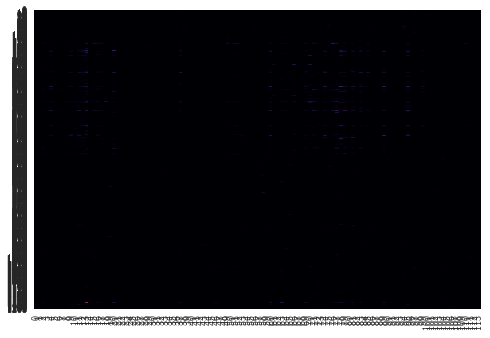

In [98]:
create_mat_plot(new_matrix, sorted_labels, taxonmies, '', 'RA' ,'','', cmap='inferno', filetype='pdf', rx=0, ry=0, font_s=10)

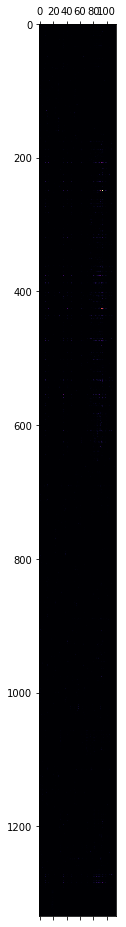